In [ ]:
import os
import shutil
import zipfile
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.utils import class_weight
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.applications.efficientnet import preprocess_input

# --- 1. Define All Your Paths ---
DRIVE_PROJECT_PATH = "/content/drive/MyDrive/"
# This is the path to your zip file
DRIVE_ZIP_PATH = f"{DRIVE_PROJECT_PATH}/archive.zip"

# This is the new, FAST local disk path
LOCAL_DATA_PATH = "/content/Dataset"
LOCAL_ZIP_PATH = "/content/archive.zip"

# Check if data is already copied
if not os.path.exists(LOCAL_DATA_PATH):
    # --- 2. Copy the single ZIP file (FAST) ---
    print(f"Copying archive.zip from Drive to local disk...")
    print("This may take 10-15 minutes, but you only do it once.")
    try:
        shutil.copy(DRIVE_ZIP_PATH, LOCAL_ZIP_PATH)
        print("Copy complete.")
    except FileNotFoundError:
        print(f"--- ERROR ---")
        print(f"Could not find archive.zip at {DRIVE_ZIP_PATH}")
        print("Please make sure archive.zip is in your AI_Project folder.")
        raise

    # --- 3. Unzip the file locally (FAST) ---
    print(f"Unzipping data to {LOCAL_DATA_PATH}...")

    with zipfile.ZipFile(LOCAL_ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(LOCAL_DATA_PATH)

    print("Unzipping complete.")

    # --- 4. Copy the CSV files ---
    # This assumes your CSVs are inside a 'Dataset' folder in your zip
    # If they are not, we will get an error in Step 1, which we can fix.
    print("Data is now local and ready for Step 1.")

else:
    print("--- Data Already Local ---")
    print(f"The {LOCAL_DATA_PATH} folder already exists. Skipping copy and unzip.")

print("\n--- Setup Complete ---")

Copying archive.zip from Drive to local disk...
This may take 10-15 minutes, but you only do it once.
Copy complete.
Unzipping data to /content/Dataset...
Unzipping complete.
Data is now local and ready for Step 1.

--- Setup Complete ---


In [ ]:
# Set Your Master Dataset Path (to the fast local disk)
DATASET_ROOT_PATH = "/content/Dataset"

# Create a New Folder for Preprocessing Objects
preprocessing_path = f"{DATASET_ROOT_PATH}/preprocessing_objects"
if not os.path.exists(preprocessing_path):
    os.makedirs(preprocessing_path)
    print(f"Created new folder for preprocessing files: {preprocessing_path}")
else:
    print(f"Preprocessing files will be saved to: {preprocessing_path}")

# Load and Merge CSVs (GroundTruth and Metadata)
print(f"\nLoading CSV files from: {DATASET_ROOT_PATH}")
try:
    df_truth = pd.read_csv(f"{DATASET_ROOT_PATH}/ISIC_2019_Training_GroundTruth.csv")
    df_meta = pd.read_csv(f"{DATASET_ROOT_PATH}/ISIC_2019_Training_Metadata.csv")
except FileNotFoundError:
    print("\n--- ERROR ---")
    print(f"Could not find the CSV files at the path: {DATASET_ROOT_PATH}")
    print("Please make sure the Setup step was successful and the CSVs are at the root of the zip.")
    raise

df_main = df_truth.merge(df_meta, on='image')

# Create Label Column (from GroundTruth)
label_columns = [col for col in df_truth.columns if col not in ['image', 'UNK']]
print(f"\nDisease classes found: {label_columns}")
df_main['label'] = df_main[label_columns].idxmax(axis=1)

# Add and Verify Image Paths (Using the Label)
print("Building and verifying image paths...")
df_main['image_path'] = DATASET_ROOT_PATH + '/' + df_main['label'] + '/' + df_main['image'] + '.jpg'

original_count = len(df_main)
df_main['file_exists'] = df_main['image_path'].apply(os.path.exists)

# Report missing files per class BEFORE dropping
missing_files_df = df_main[df_main['file_exists'] == False]
if len(missing_files_df) > 0:
    print("\n--- WARNING: Missing Image Files Detected ---")
    print("The following images listed in the CSV could not be found in their folders:")
    print(missing_files_df['label'].value_counts())
    print("--------------------------------------------------")
else:
    print("All image paths verified successfully.")

df_main = df_main[df_main['file_exists'] == True]
print(f"Removed {original_count - len(df_main)} total rows with missing/invalid image paths.")
df_main = df_main.drop(columns=['file_exists'])

# Verify Class Distribution After Filtering
print("\n--- Final Class Distribution (After Filtering) ---")
print(f"Total images remaining for training/testing: {len(df_main)}")
print(df_main['label'].value_counts())
print("--------------------------------------------------")


# Pre-Shuffle, Encode Labels, and Split (BEFORE Preprocessing)
print("Shuffling data before splitting...")
df_main = df_main.sample(frac=1, random_state=42).reset_index(drop=True)

label_encoder = LabelEncoder()
df_main['label_encoded'] = label_encoder.fit_transform(df_main['label'])
joblib.dump(label_encoder, f'{preprocessing_path}/label_encoder.pkl')

train_df, test_df = train_test_split(
    df_main,
    test_size=0.2,
    random_state=42,
    stratify=df_main['label_encoded']
)

train_df = train_df.copy()
test_df = test_df.copy()

print(f"\nTraining samples: {len(train_df)}")
print(f"Testing samples: {len(test_df)}")


# Preprocess Metadata (No Data Leakage)
print("Preprocessing metadata (fitting on training data only)...")
numerical_cols = ['age_approx']
categorical_cols = ['sex', 'anatom_site_general']

# Fill NaNs
train_age_mean = train_df[numerical_cols].mean()
train_df.loc[:, numerical_cols] = train_df[numerical_cols].fillna(train_age_mean)
test_df.loc[:, numerical_cols] = test_df[numerical_cols].fillna(train_age_mean)
train_df.loc[:, categorical_cols] = train_df[categorical_cols].fillna('unknown')
test_df.loc[:, categorical_cols] = test_df[categorical_cols].fillna('unknown')

# Scale Numerical (Age)
scaler = StandardScaler()
train_df.loc[:, numerical_cols] = scaler.fit_transform(train_df[numerical_cols])
test_df.loc[:, numerical_cols] = scaler.transform(test_df[numerical_cols])
joblib.dump(scaler, f'{preprocessing_path}/age_scaler.pkl')

# One-Hot Encode Categorical
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
train_encoded_features = encoder.fit_transform(train_df[categorical_cols])
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)
joblib.dump(encoder, f'{preprocessing_path}/metadata_encoder.pkl')

train_encoded_df = pd.DataFrame(train_encoded_features, columns=encoded_feature_names, index=train_df.index)
test_encoded_features = encoder.transform(test_df[categorical_cols])
test_encoded_df = pd.DataFrame(test_encoded_features, columns=encoded_feature_names, index=test_df.index)

train_df = train_df.drop(columns=categorical_cols)
test_df = test_df.drop(columns=categorical_cols)
print(f"Dropped original text columns.")

train_df = train_df.join(train_encoded_df)
test_df = test_df.join(test_encoded_df)
print(f"Added {len(encoded_feature_names)} one-hot encoded columns.")

# Save Metadata Column List
metadata_columns = numerical_cols + list(encoded_feature_names)
train_df[metadata_columns] = train_df[metadata_columns].astype('float32')
test_df[metadata_columns] = test_df[metadata_columns].astype('float32')
print(f"\nFinal metadata features: {metadata_columns}")
print(f"Final number of metadata features: {len(metadata_columns)}")
joblib.dump(metadata_columns, f'{preprocessing_path}/metadata_columns.pkl')

# Drop Leaky and Unused Columns
columns_to_drop = list(label_columns)
if 'UNK' in train_df.columns:
    columns_to_drop.append('UNK')
train_df = train_df.drop(columns=columns_to_drop)
test_df = test_df.drop(columns=columns_to_drop)
print(f"Dropped {len(columns_to_drop)} leaky original label columns.")

# Calculate and SAVE Class Weights
print("Calculating class weights from training data...")
class_weights_array = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_df['label_encoded']),
    y=train_df['label_encoded']
)
class_weights_dict = dict(enumerate(class_weights_array))
joblib.dump(class_weights_dict, f'{preprocessing_path}/class_weights.pkl')
print(f"Class weights computed and saved: {class_weights_dict}")

# Save Processed DataFrames
print("\nSaving processed dataframes locally...")
train_save_path = f"{DATASET_ROOT_PATH}/train_processed.csv"
test_save_path = f"{DATASET_ROOT_PATH}/test_processed.csv"
train_df.to_csv(train_save_path, index=False)
test_df.to_csv(test_save_path, index=False)
print(f"Saved processed data to {train_save_path} and {test_save_path}")

print("\n--- Step 1 Complete ---")

Created new folder for preprocessing files: /content/Dataset/preprocessing_objects

Loading CSV files from: /content/Dataset

Disease classes found: ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']
Building and verifying image paths...
All image paths verified successfully.
Removed 0 total rows with missing/invalid image paths.

--- Final Class Distribution (After Filtering) ---
Total images remaining for training/testing: 25331
label
NV      12875
MEL      4522
BCC      3323
BKL      2624
AK        867
SCC       628
VASC      253
DF        239
Name: count, dtype: int64
--------------------------------------------------
Shuffling data before splitting...

Training samples: 20264
Testing samples: 5067
Preprocessing metadata (fitting on training data only)...
Dropped original text columns.
Added 12 one-hot encoded columns.

Final metadata features: ['age_approx', 'sex_female', 'sex_male', 'sex_unknown', 'anatom_site_general_anterior torso', 'anatom_site_general_head/neck', 'anatom_

In [ ]:
# Define Your Paths
# This path points to the FAST local disk
DATASET_ROOT_PATH = "/content/Dataset"
preprocessing_path = f"{DATASET_ROOT_PATH}/preprocessing_objects"

# Load the Processed DataFrames and Metadata Columns
print("Loading processed data files from local disk...")
try:
    train_df = pd.read_csv(f"{DATASET_ROOT_PATH}/train_processed.csv")
    test_df = pd.read_csv(f"{DATASET_ROOT_PATH}/test_processed.csv")
    metadata_columns = joblib.load(f"{preprocessing_path}/metadata_columns.pkl")
    print(f"Successfully loaded {len(train_df)} training rows and {len(test_df)} testing rows.")
except FileNotFoundError:
    print("\n--- ERROR ---")
    print("Could not find processed files. Please run the 'Copy Data' and 'Step 1' cells again.")
    raise

# Define Constants
IMG_WIDTH = 224
IMG_HEIGHT = 224
N_CLASSES = len(train_df['label_encoded'].unique()) # 8
BATCH_SIZE = 32
N_META_FEATURES = len(metadata_columns) # 13

print(f"Constants set: Image Size=({IMG_HEIGHT}, {IMG_WIDTH}), Classes={N_CLASSES}, Batch Size={BATCH_SIZE}")

# Helper Function for the tf.data Pipeline
def load_and_preprocess(image_path, meta_features, label):
    """
    Loads, decodes, and preprocesses one sample for the tf.data pipeline.
    """
    # Load and Preprocess Image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

    # Use the correct preprocessing for EfficientNet
    img = preprocess_input(img)

    # One-Hot Encode Label
    label = tf.one_hot(label, depth=N_CLASSES)

    # Return in the ( (inputs), output ) format
    return (img, meta_features), label

# Create the tf.data.Dataset from Pandas DataFrames
train_image_paths = train_df['image_path'].values
train_meta_features = train_df[metadata_columns].values.astype('float32')
train_labels = train_df['label_encoded'].values

test_image_paths = test_df['image_path'].values
test_meta_features = test_df[metadata_columns].values.astype('float32')
test_labels = test_df['label_encoded'].values

# Define AUTOTUNE for parallel prefetching
AUTOTUNE = tf.data.AUTOTUNE

# Create the Training Pipeline
print("Building training data pipeline for EfficientNetB0 (224x224)...")
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_image_paths, train_meta_features, train_labels)
)
train_ds = (
    train_ds
    .shuffle(buffer_size=len(train_df)) # Shuffle the data
    .map(load_and_preprocess, num_parallel_calls=AUTOTUNE) # Preprocess in parallel
    .batch(BATCH_SIZE) # Create batches
    .prefetch(buffer_size=AUTOTUNE) # Prefetch batches to the GPU
)

# Create the Testing (Validation) Pipeline
print("Building testing data pipeline for EfficientNetB0 (224x224)...")
test_ds = tf.data.Dataset.from_tensor_slices(
    (test_image_paths, test_meta_features, test_labels)
)
test_ds = (
    test_ds
    .map(load_and_preprocess, num_parallel_calls=AUTOTUNE) # Just preprocess
    .batch(BATCH_SIZE) # Create batches
    .prefetch(buffer_size=AUTOTUNE) # Prefetch batches
)

print("\n--- Step 2 Complete ---")
print("High-performance tf.data pipelines (for 224x224) are created.")

Loading processed data files from local disk...
Successfully loaded 20264 training rows and 5067 testing rows.
Constants set: Image Size=(224, 224), Classes=8, Batch Size=32
Building training data pipeline for EfficientNetB0 (224x224)...
Building testing data pipeline for EfficientNetB0 (224x224)...

--- Step 2 Complete ---
High-performance tf.data pipelines (for 224x224) are created.


In [ ]:
# Enable Mixed Precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print('Mixed precision enabled. Compute dtype: %s' % policy.compute_dtype)

# Define Constants (matching Step 2)
IMG_WIDTH = 224
IMG_HEIGHT = 224
N_CLASSES = 8
N_META_FEATURES = 13

# Image Branch (CNN)
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

# Freeze the entire base model for Phase 1
base_model.trainable = False

# Define the image input
image_input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), name='image_input')
# Call the base model in inference mode to keep BN stats frozen
x = base_model(image_input, training=False)
x = GlobalAveragePooling2D()(x)

# BN before Activation
x = Dense(128, use_bias=False)(x) # bias=False
x = BatchNormalization()(x)
x = Activation('swish')(x)
cnn_output = Dropout(0.3)(x)

# Metadata Branch (MLP)
meta_input_shape = (N_META_FEATURES,)
meta_input = Input(shape=meta_input_shape, name='metadata_input')

# BN before Activation
y = Dense(64, use_bias=False)(meta_input) # bias=False
y = BatchNormalization()(y)
y = Activation('swish')(y)

y = Dense(32, use_bias=False)(y) # bias=False
y = BatchNormalization()(y)
mlp_output = Activation('swish')(y)

# Merge the Branches
combined = Concatenate()([cnn_output, mlp_output])

# Final Head
# BN before Activation
z = Dense(64, use_bias=False)(combined) # bias=False
z = BatchNormalization()(z)
z = Activation('swish')(z)
z = Dropout(0.6)(z)

# The final layer MUST be float32 and keeps its bias
z = Dense(N_CLASSES, activation='softmax', dtype='float32')(z)

# Create and Compile the Model
model = Model(inputs=[image_input, meta_input], outputs=z)

# Use AdamW Optimizer
model.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5), # 1e-3 LR for the new head
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()
print("\n--- Step 3 Complete ---")
print("Model (EfficientNetB0, Phase 1) is built and compiled.")

Mixed precision enabled. Compute dtype: float16
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ metadata_input      │ (None, 13)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 7, 7,      │  4,049,571 │ image_input[0][0] │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │        832 │ metadata_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    163,840 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64)        │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,048 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32)        │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 160)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │     10,240 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64)        │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 4,228,203 (16.13 MB)

 Trainable params: 178,056 (695.53 KB)

 Non-trainable params: 4,050,147 (15.45 MB)


--- Step 3 Complete ---
Model (EfficientNetB0, Phase 1) is built and compiled.


In [ ]:
# Define Your Paths
DATASET_ROOT_PATH = "/content/Dataset"
preprocessing_path = f"{DATASET_ROOT_PATH}/preprocessing_objects"

# Load the Class Weights
print("Loading class weights...")
try:
    class_weights_dict = joblib.load(f"{preprocessing_path}/class_weights.pkl")
    print(f"Loaded class weights: {class_weights_dict}")
except FileNotFoundError:
    print("\n--- ERROR ---")
    print("Could not find class_weights.pkl. Please run Step 1 again.")
    raise

# Define Callbacks
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3, # Set to 3 as you requested
    min_lr=1e-7,
    verbose=1
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8, # Set to 8 to work well with patience=3
    restore_best_weights=True
)

# Train the Model
print("\nStarting initial model training (Phase 1: Head Only)...")
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20, # Max 20 epochs
    class_weight=class_weights_dict,
    callbacks=[lr_scheduler, early_stop],
    verbose=1
)

print("\n--- Step 4 Complete ---")
print("Initial 'head' training finished. Best weights are restored.")

In [ ]:
# Unfreeze the top layers of the base model
print(f"Unfreezing the last 30 layers of the EfficientNetB0 model for fine-tuning...")
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Re-compile the model with a low LR for fine-tuning
model.compile(
    optimizer=AdamW(learning_rate=1e-5, weight_decay=1e-5), # Use a low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model re-compiled with a low learning rate for fine-tuning.")
model.summary()

print("\n--- Step 6 Complete ---")

Unfreezing the last 30 layers of the EfficientNetB0 model for fine-tuning...
Model re-compiled with a low learning rate for fine-tuning.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ metadata_input      │ (None, 13)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 7, 7,      │  4,049,571 │ image_input[0][0] │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │        832 │ metadata_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    163,840 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64)        │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,048 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32)        │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 160)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │     10,240 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64)        │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 4,228,203 (16.13 MB)

 Trainable params: 1,674,216 (6.39 MB)

 Non-trainable params: 2,553,987 (9.74 MB)


--- Step 6 Complete ---


In [ ]:
# Define the path to save your model in your Google Drive
DRIVE_PROJECT_PATH = "/content/drive/MyDrive/"
MODEL_SAVE_PATH_PHASE1 = f"{DRIVE_PROJECT_PATH}/skin_disease_model_PHASE1_B0.keras"

print(f"Saving current model state to: {MODEL_SAVE_PATH_PHASE1}")

# Save the model
model.save(MODEL_SAVE_PATH_PHASE1)

print("--- Model Saved Successfully to Google Drive ---")

Saving current model state to: /content/drive/MyDrive//skin_disease_model_PHASE1_B0.keras
--- Model Saved Successfully to Google Drive ---


In [ ]:
# Continue Training (Fine-Tuning)
print("Starting fine-tune training (Phase 2)...")

# We use the *same* callbacks.
history_finetune = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=15,
    class_weight=class_weights_dict,
    callbacks=[lr_scheduler, early_stop],
    verbose=1
)

print("\n--- Step 7 Complete ---")
print("Model fine-tuning finished. Best weights are restored.")

Starting fine-tune training (Phase 2)...
Epoch 1/15
634/634 ━━━━━━━━━━━━━━━━━━━━ 216s 341ms/step - accuracy: 0.5317 - loss: 1.1475 - val_accuracy: 0.5879 - val_loss: 1.1005 - learning_rate: 1.0000e-05
Epoch 2/15
634/634 ━━━━━━━━━━━━━━━━━━━━ 202s 319ms/step - accuracy: 0.5524 - loss: 1.0832 - val_accuracy: 0.5936 - val_loss: 1.0762 - learning_rate: 1.0000e-05
Epoch 3/15
634/634 ━━━━━━━━━━━━━━━━━━━━ 201s 318ms/step - accuracy: 0.5600 - loss: 1.0455 - val_accuracy: 0.5936 - val_loss: 1.0751 - learning_rate: 1.0000e-05
Epoch 4/15
634/634 ━━━━━━━━━━━━━━━━━━━━ 202s 319ms/step - accuracy: 0.5631 - loss: 1.0285 - val_accuracy: 0.6051 - val_loss: 1.0389 - learning_rate: 1.0000e-05
Epoch 5/15
634/634 ━━━━━━━━━━━━━━━━━━━━ 261s 318ms/step - accuracy: 0.5663 - loss: 1.0082 - val_accuracy: 0.6094 - val_loss: 1.0227 - learning_rate: 1.0000e-05
Epoch 6/15
634/634 ━━━━━━━━━━━━━━━━━━━━ 203s 320ms/step - accuracy: 0.5732 - loss: 0.9590 - val_accuracy: 0.6106 - val_loss: 1.0187 - learning_rate: 1.0000e-05


Generating predictions on the test set...
159/159 ━━━━━━━━━━━━━━━━━━━━ 34s 213ms/step

--- Classification Report ---
              precision    recall  f1-score   support

          AK       0.32      0.74      0.45       173
         BCC       0.63      0.58      0.60       665
         BKL       0.47      0.56      0.51       525
          DF       0.19      0.69      0.30        48
         MEL       0.58      0.55      0.56       904
          NV       0.92      0.70      0.79      2575
         SCC       0.29      0.65      0.40       126
        VASC       0.30      0.94      0.46        51

    accuracy                           0.64      5067
   macro avg       0.46      0.68      0.51      5067
weighted avg       0.72      0.64      0.67      5067


--- Confusion Matrix ---


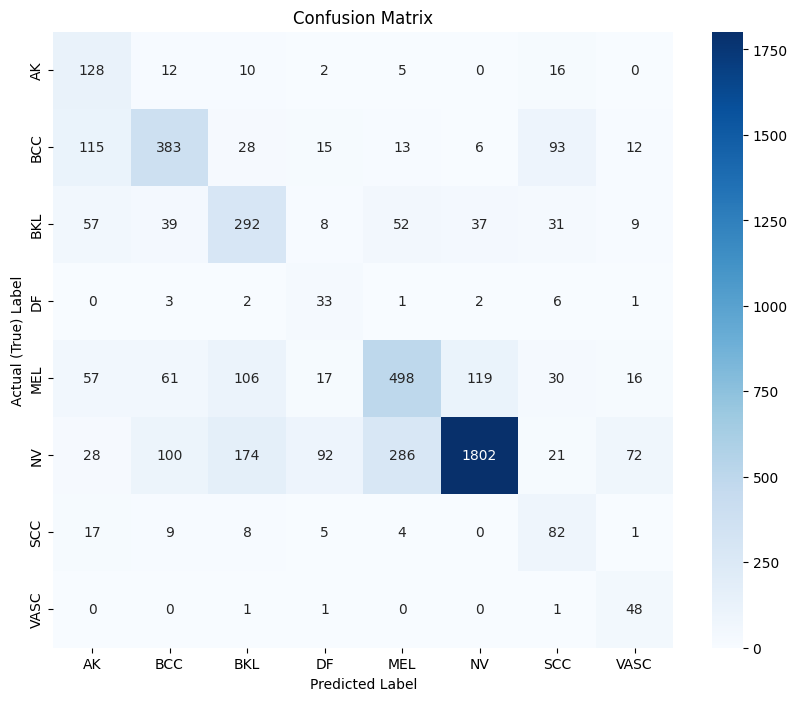


Saving final trained model to: /content/drive/MyDrive//skin_disease_model_B0.keras
--- Model Saved Successfully to Google Drive ---

--- Final Analysis Complete ---


In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt

# --- Load the label encoder to get class names ---
# Define Your Paths
DATASET_ROOT_PATH = "/content/Dataset"
preprocessing_path = f"{DATASET_ROOT_PATH}/preprocessing_objects"
DRIVE_PROJECT_PATH = "/content/drive/MyDrive/"

label_encoder = joblib.load(f"{preprocessing_path}/label_encoder.pkl")
class_names = label_encoder.classes_

# --- Get true labels and predictions ---
print("\nGenerating predictions on the test set...")
# Ensure test_ds is still in memory from the last successful run of Step 2/3
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true_labels = np.argmax(y_true, axis=1)

y_pred_probs = model.predict(test_ds)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# --- Classification Report ---
print("\n--- Classification Report ---")
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

# --- Confusion Matrix ---
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual (True) Label')
plt.xlabel('Predicted Label')
plt.show()

# --- Save the Final Model to Google Drive ---
MODEL_SAVE_PATH = f"{DRIVE_PROJECT_PATH}/skin_disease_model_B0.keras"

print(f"\nSaving final trained model to: {MODEL_SAVE_PATH}")
# Save the model
model.save(MODEL_SAVE_PATH)
print("--- Model Saved Successfully to Google Drive ---")


print("\n--- Final Analysis Complete ---")

In [ ]:
import joblib
import os

# --- 1. Define the Permanent Drive Path ---
# NOTE: This path must match the structure you used in the Streamlit app.
DRIVE_PROJECT_PATH = "/content/drive/MyDrive/"
DRIVE_PREPROCESSING_PATH = f"{DRIVE_PROJECT_PATH}/preprocessing_objects"

# Check if the target folder exists on Drive
if not os.path.exists(DRIVE_PREPROCESSING_PATH):
    os.makedirs(DRIVE_PREPROCESSING_PATH)
    print(f"Created directory: {DRIVE_PREPROCESSING_PATH}")


# --- 2. Save All Objects Permanently ---
print("\nSaving 4 preprocessing objects to Google Drive...")

# 1. Label Encoder (for disease names)
joblib.dump(label_encoder, f'{DRIVE_PREPROCESSING_PATH}/label_encoder.pkl')

# 2. Age Scaler (for numerical feature normalization)
joblib.dump(scaler, f'{DRIVE_PREPROCESSING_PATH}/age_scaler.pkl')

# 3. Metadata OneHotEncoder (for sex and anatomical site)
joblib.dump(encoder, f'{DRIVE_PREPROCESSING_PATH}/metadata_encoder.pkl')

# 4. Final Column List (ensures correct feature order)
joblib.dump(metadata_columns, f'{DRIVE_PREPROCESSING_PATH}/metadata_columns.pkl')

print("\n✅ All preprocessing files saved successfully to Google Drive.")

Created directory: /content/drive/MyDrive//preprocessing_objects

Saving 4 preprocessing objects to Google Drive...

✅ All preprocessing files saved successfully to Google Drive.
